# Creating idealized clouds with Tb and precipitation
### This notebook demonstrates generating synthetic cloud data for testing the tracking code.
- Create cloud-like structures using Gaussian filters
- Save the data in NetCDF format
- Visualize the results

### Authors: 
- Laura Paccini <laura.paccini@pnnl.gov>
- Zhe Feng <zhe.feng@pnnl.gov>


In [1]:
import os
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

### 1.  Prepare Parameters

In [2]:
# Parameters
domain_size = (200, 150)  # (y, x) - flipped from original (150, 200)
timesteps = 24

# Cloud parameters
# Define the parameters for each cloud in a dictionary
clouds = [
    {
        'name': 'Cloud 1',
        'initial_center_x': domain_size[1] // 5,  # Changed from domain_size[0]
        'initial_center_y': domain_size[0] // 4 * 3,  # Changed from domain_size[1]
        'dx': 1,  # Initial movement direction in x (1 for right, -1 for left)
        'dy': 0,  # Initial movement direction in y (1 for up, -1 for down)
        'move_x': domain_size[1] // (timesteps * 1.5),  # Changed from domain_size[0]
        'move_y': 0,
        'sigma_tb_min': 0.15, # Minimum sigma for Tb Gaussian (initial cloud size)
        'sigma_tb_max': 6,       # Maximum sigma for Tb Gaussian (maximum cloud size)
        'amplitude_tb_min': 0.05,  # Initial amplitude of Tb Gaussian (initial intensity)
        'amplitude_tb_max': 1.0,   # Maximum amplitude of Tb Gaussian (peak intensity)
        'sigma_pr_min': 0.05,    # Minimum sigma for pr Gaussian (initial precipitation area size)
        'sigma_pr_max': 4,       # Maximum sigma for pr Gaussian (maximum precipitation area size)
        'amplitude_pr_min': 0.5,   # Initial amplitude of pr Gaussian (initial precipitation intensity)
        'amplitude_pr_max': 1.0,   # Maximum amplitude of pr Gaussian (peak precipitation intensity)
    },
    {
        'name': 'Cloud 2',
        'initial_center_x': domain_size[1] // 5,  # Changed from domain_size[0]
        'initial_center_y': domain_size[0] // 4 * 2,  # Changed from domain_size[1]
        'dx': 1,  # Moves left
        'dy': 0,  # Moves down
        'move_x': domain_size[1] // (timesteps * 1.5),  # Changed from domain_size[0]
        'move_y': 0,
        'sigma_tb_min': 0.15,
        'sigma_tb_max': 7,
        'amplitude_tb_min': 0.05,
        'amplitude_tb_max': 1.0,
        'sigma_pr_min': 0.05,
        'sigma_pr_max': 4,
        'amplitude_pr_min': 0.5,
        'amplitude_pr_max': 1.0,
    },
    {
        'name': 'Cloud 3',
        'initial_center_x': domain_size[1] // 5,  # Changed from domain_size[0]
        'initial_center_y': domain_size[0] // 4,  # Changed from domain_size[1]
        'dx': 1,  # Moves left
        'dy': 0,  # Moves down
        'move_x': domain_size[1] // (timesteps * 1.5),  # Changed from domain_size[0]
        'move_y': 0,
        'sigma_tb_min': 0.15,
        'sigma_tb_max': 1,
        'amplitude_tb_min': 0.05,
        'amplitude_tb_max': 1.0,
        'sigma_pr_min': 0.05,
        'sigma_pr_max': 4,
        'amplitude_pr_min': 0.5,
        'amplitude_pr_max': 1.0,
    },
]

# Other parameters
growth_timestep = 15   # Timestep at which the cloud reaches maximum size and intensity

tb_exponent = 3        # Exponent for shaping Tb profile (controls sharpness of temperature gradient)
pr_exponent = 1        # Exponent for shaping pr profile (controls precipitation rate distribution)
pr_max = 20            # Maximum precipitation rate (mm/hr)

### 2. Create Clouds

This section generates synthetic clouds using Gaussian filters or other methods. The clouds are created as 2D arrays with varying intensity and size.

In [3]:
# Generate a meshgrid for the domain
y = np.linspace(0, domain_size[0] - 1, domain_size[0])  # y comes from domain_size[0]
x = np.linspace(0, domain_size[1] - 1, domain_size[1])  # x comes from domain_size[1]
x_grid, y_grid = np.meshgrid(x, y)

# Function to create a circular Gaussian distribution
def create_gaussian(center_x, center_y, sigma_x, sigma_y, amplitude):
    gauss = amplitude * np.exp(-(((x_grid - center_x) ** 2) / (2 * sigma_x ** 2) +
                                 ((y_grid - center_y) ** 2) / (2 * sigma_y ** 2)))
    return gauss

# Initialize data arrays
Tb = np.full((timesteps, domain_size[0], domain_size[1]), 300.0)
pr = np.zeros((timesteps, domain_size[0], domain_size[1]))   

# Initialize clouds
for cloud in clouds:
    # Initialize current positions
    cloud['center_x'] = cloud['initial_center_x']
    cloud['center_y'] = cloud['initial_center_y']
    # Initialize lists to store center positions over time for visualization
    cloud['center_positions_x'] = []
    cloud['center_positions_y'] = []
    # Define buffer to prevent cloud from touching edges
    cloud['buffer_tb'] = cloud['sigma_tb_max'] * 3
    # Define boundaries for the center positions
    cloud['min_center_x'] = cloud['buffer_tb']
    cloud['max_center_x'] = domain_size[1] - cloud['buffer_tb']
    cloud['min_center_y'] = cloud['buffer_tb']
    cloud['max_center_y'] = domain_size[0] - cloud['buffer_tb']

# Main simulation loop
for t in range(timesteps):
    # Calculate the growth factor f(t)
    if t <= growth_timestep:
        f = t / growth_timestep
    else:
        f = (timesteps - t - 1) / (timesteps - growth_timestep - 1)

    # Initialize lists to store normalized Tb and pr for combining
    tb_normalized_list = []
    pr_normalized_list = []

    # Update each cloud
    for cloud in clouds:
        # Adjust sigma and amplitude using f(t)
        sigma_tb = cloud['sigma_tb_min'] + f * (cloud['sigma_tb_max'] - cloud['sigma_tb_min'])
        amplitude_tb = cloud['amplitude_tb_min'] + f * (cloud['amplitude_tb_max'] - cloud['amplitude_tb_min'])
        sigma_pr = cloud['sigma_pr_min'] + f * (cloud['sigma_pr_max'] - cloud['sigma_pr_min'])
        amplitude_pr = cloud['amplitude_pr_min'] + f * (cloud['amplitude_pr_max'] - cloud['amplitude_pr_min'])

        # Adjust Gaussian properties for Tb
        tb_gaussian = create_gaussian(cloud['center_x'], cloud['center_y'],
                                      sigma_x=sigma_tb, sigma_y=sigma_tb, amplitude=amplitude_tb)
        tb_gaussian_filtered = gaussian_filter(tb_gaussian, sigma=2)
        tb_normalized = tb_gaussian_filtered / np.max(tb_gaussian_filtered)
        tb_normalized_list.append(tb_normalized)

        # Adjust Gaussian properties for pr
        pr_gaussian = create_gaussian(cloud['center_x'], cloud['center_y'],
                                      sigma_x=sigma_pr, sigma_y=sigma_pr, amplitude=amplitude_pr)
        pr_gaussian_filtered = gaussian_filter(pr_gaussian, sigma=2)
        pr_normalized = pr_gaussian_filtered / np.max(pr_gaussian_filtered)
        pr_normalized_list.append(pr_normalized)

        # Store center positions for visualization
        cloud['center_positions_x'].append(cloud['center_x'])
        cloud['center_positions_y'].append(cloud['center_y'])

        # Move the Gaussian center for next timestep
        cloud['center_x'] += cloud['dx'] * cloud['move_x']
        cloud['center_y'] += cloud['dy'] * cloud['move_y']

        # Check for boundary collisions and reverse direction if necessary
        if cloud['center_x'] >= cloud['max_center_x']:
            cloud['center_x'] = cloud['max_center_x']
            cloud['dx'] *= -1
        elif cloud['center_x'] <= cloud['min_center_x']:
            cloud['center_x'] = cloud['min_center_x']
            cloud['dx'] *= -1
        if cloud['center_y'] >= cloud['max_center_y']:
            cloud['center_y'] = cloud['max_center_y']
            cloud['dy'] *= -1
        elif cloud['center_y'] <= cloud['min_center_y']:
            cloud['center_y'] = cloud['min_center_y']
            cloud['dy'] *= -1

    # Combine Tb from all clouds, taking the minimum (coldest temperature) at each point
    Tb_combined = np.full((domain_size[0], domain_size[1]), 300.0)
    for tb_normalized in tb_normalized_list:
        Tb_core = 220 + (13 * (1 - tb_normalized) ** tb_exponent)
        Tb_core = np.clip(Tb_core, 220, 240)
        Tb_combined = np.minimum(Tb_combined, np.where(tb_normalized > 0.01, Tb_core, 300.0))
    Tb[t] = Tb_combined

    # Combine pr from all clouds, summing the precipitation rates
    pr_combined = np.zeros((domain_size[0], domain_size[1]))
    for pr_normalized in pr_normalized_list:
        pr_scaled = pr_max * pr_normalized ** pr_exponent
        pr_threshold = 0.001
        pr_field = np.where(pr_normalized > pr_threshold, pr_scaled, 0.0)
        pr_combined += pr_field
    pr[t] = pr_combined



### 3. Visualization of Synthetic Clouds

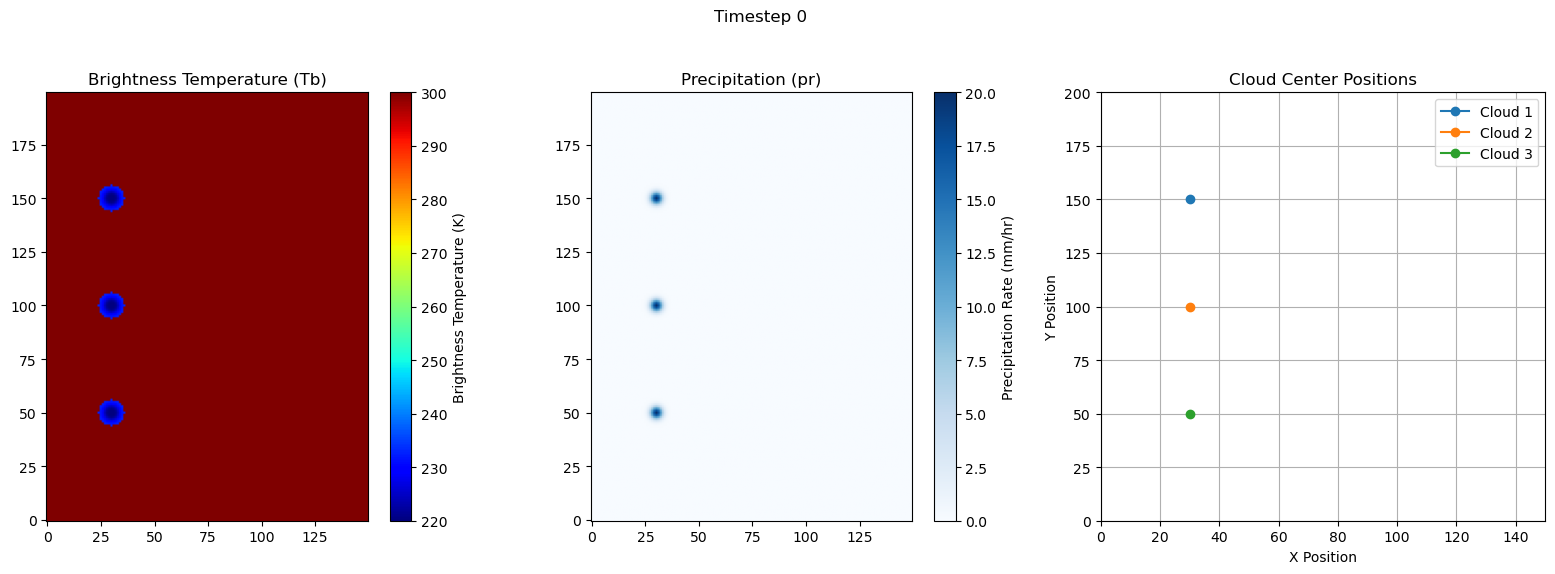

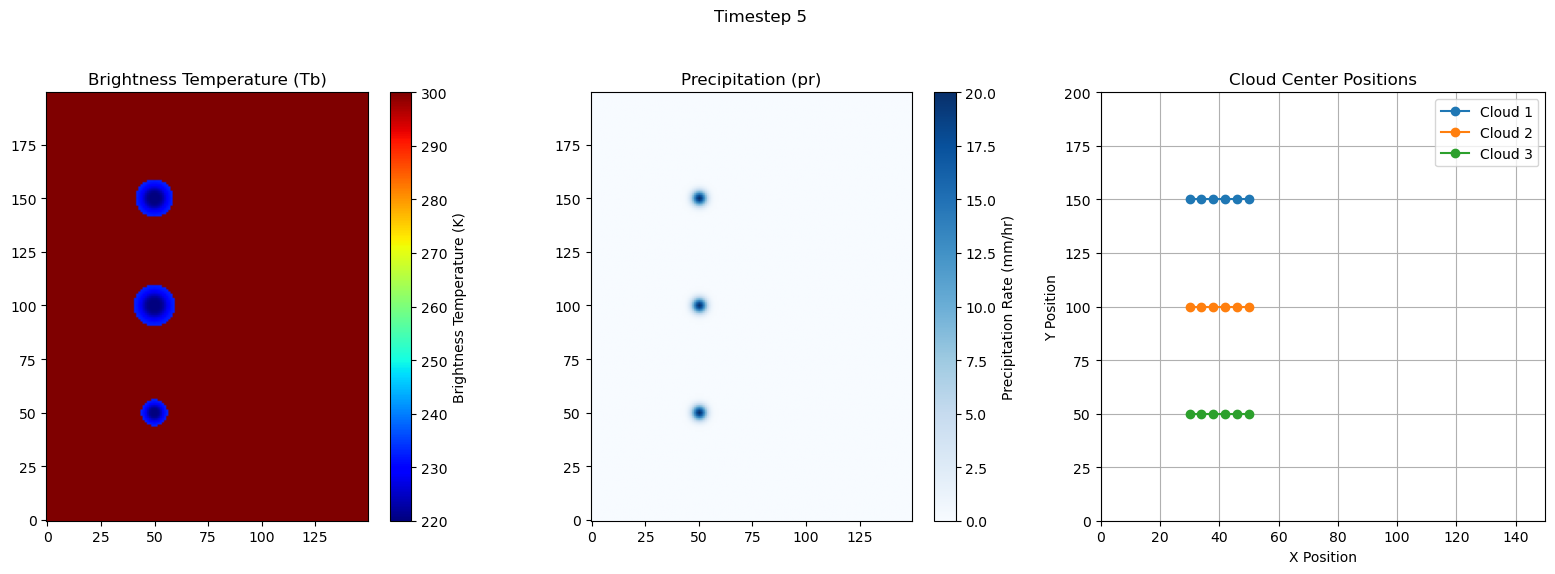

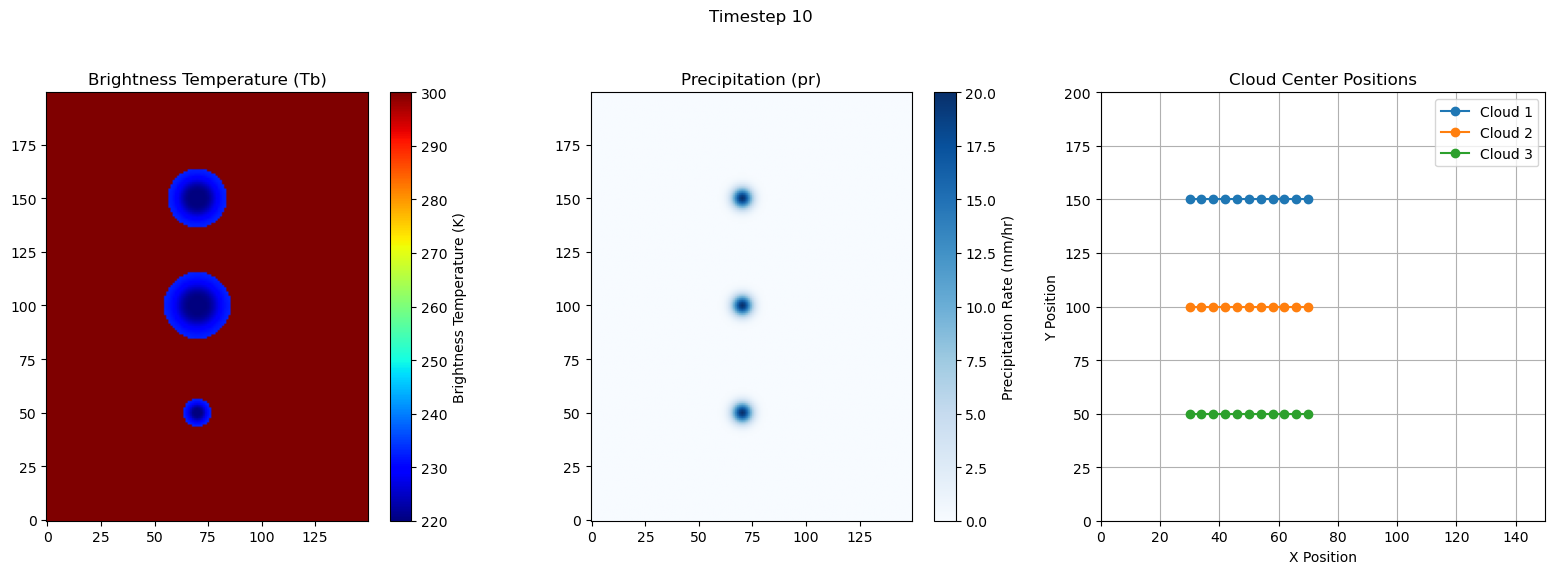

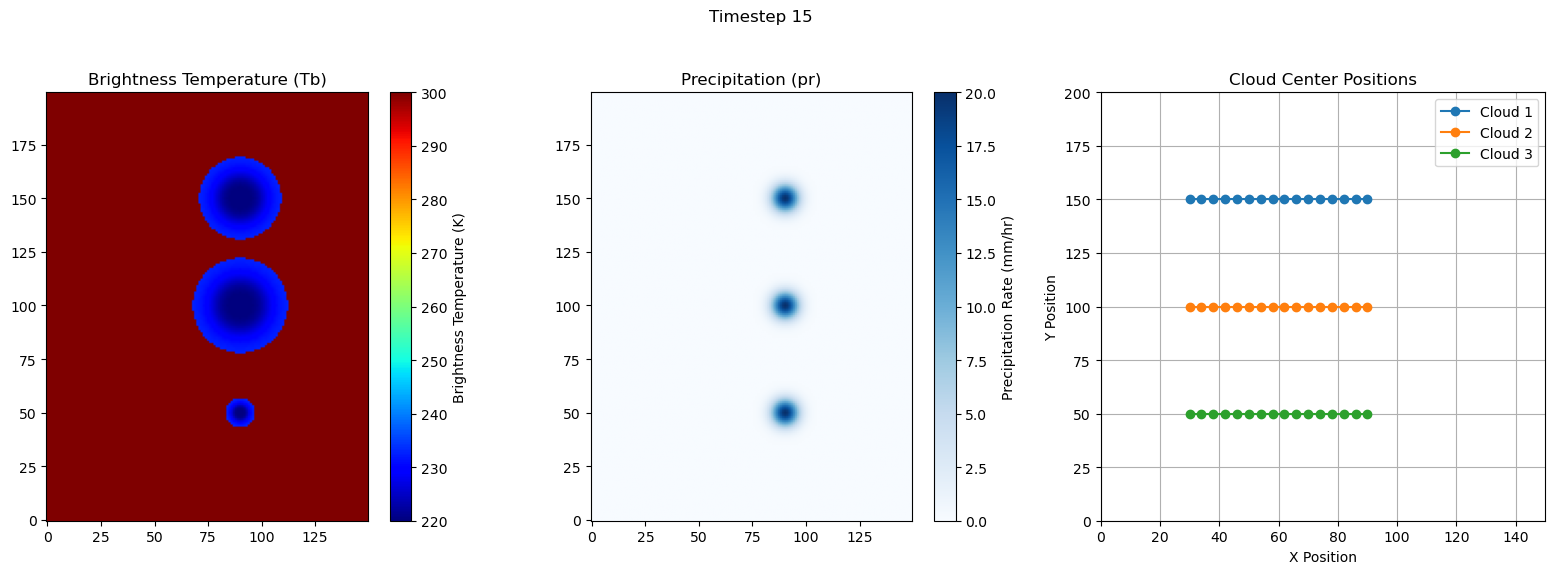

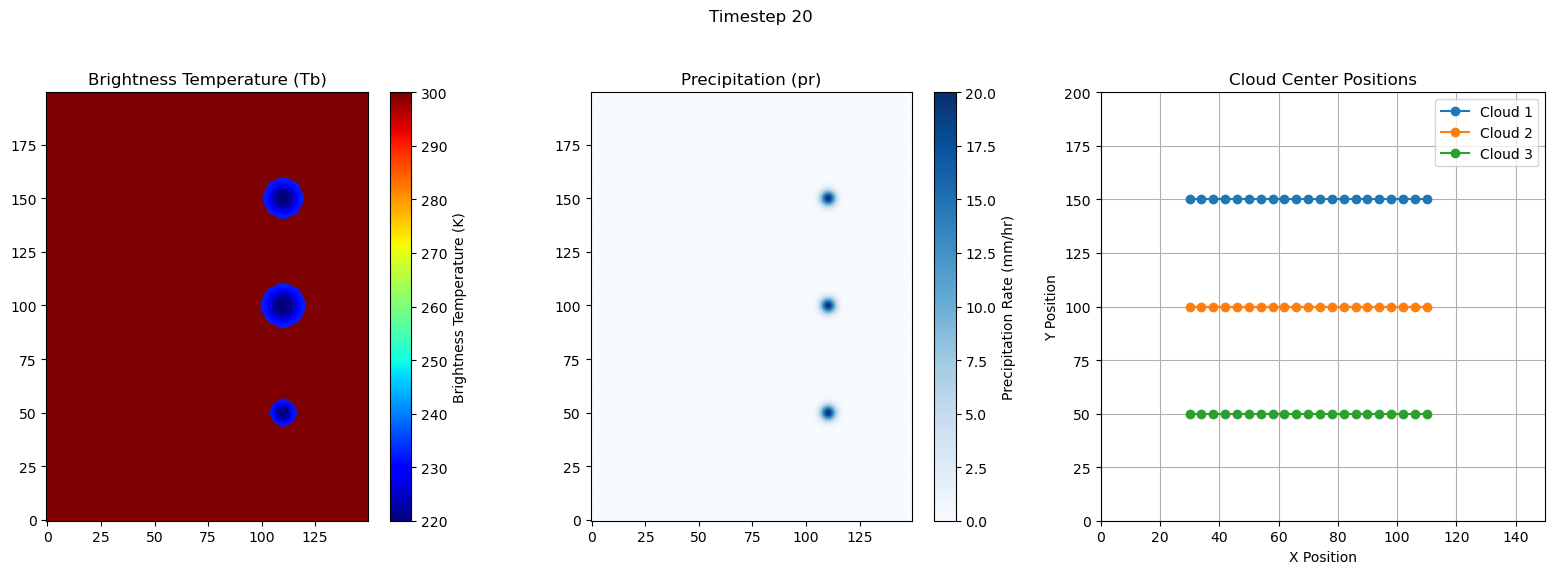

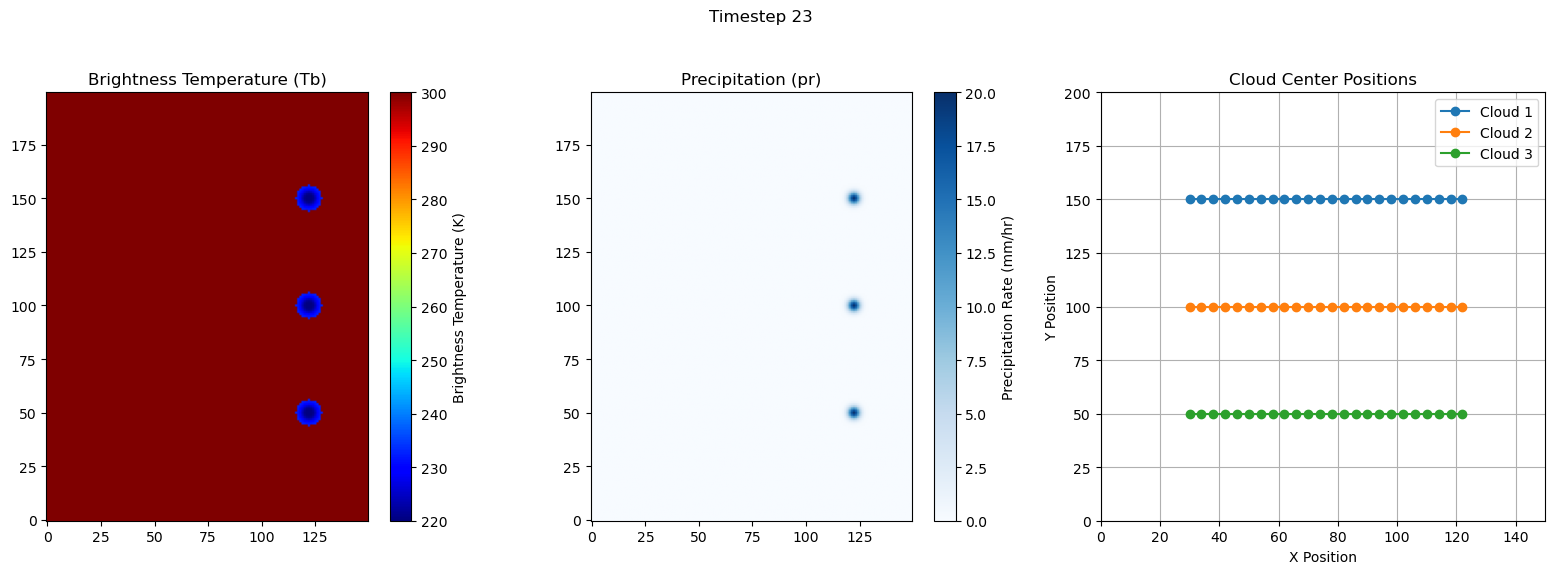

In [4]:
timesteps_to_plot = [0, 5, 10, 15, 20, timesteps - 1]  # Example timesteps

for timestep in timesteps_to_plot:
    plt.figure(figsize=(16, 6))
    plt.suptitle(f'Timestep {timestep}')
    # Plot Tb
    plt.subplot(1, 3, 1)
    plt.imshow(Tb[timestep], cmap='jet', origin='lower')
    plt.colorbar(label='Brightness Temperature (K)')
    plt.title('Brightness Temperature (Tb)')

    # Plot pr
    plt.subplot(1, 3, 2)
    plt.imshow(pr[timestep], cmap='Blues', origin='lower')
    plt.colorbar(label='Precipitation Rate (mm/hr)')
    plt.title('Precipitation (pr)')

    # Plot cloud positions
    plt.subplot(1, 3, 3)
    for cloud in clouds:
        plt.plot(cloud['center_positions_x'][:timestep + 1], cloud['center_positions_y'][:timestep + 1],
                 marker='o', label=cloud['name'])
    plt.xlim(0, domain_size[1])
    plt.ylim(0, domain_size[0])
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Cloud Center Positions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 4. Prepare data and save in NetCDF format 

In [5]:
## Setting Spatial Resolution and Converting Grid Indices to Physical Coordinates

# Define grid indices for the spatial dimensions
xc = np.arange(domain_size[1])  # Grid indices along the x-axis (from 0 to domain width)
yc = np.arange(domain_size[0])  # Grid indices along the y-axis (from 0 to domain height)

dx = 10 # Spatial resolution in km per grid cell
xc_km = xc * dx  # X coordinates in km
yc_km = yc * dx  # Y coordinates in km

In [6]:
# Create a time array starting from 2020-01-01 00:00 with hourly intervals
start_time = datetime(2020, 1, 1, 0, 0, 0)
time_coord = np.array([start_time + timedelta(hours=i) for i in range(timesteps)])
time_coord

array([datetime.datetime(2020, 1, 1, 0, 0),
       datetime.datetime(2020, 1, 1, 1, 0),
       datetime.datetime(2020, 1, 1, 2, 0),
       datetime.datetime(2020, 1, 1, 3, 0),
       datetime.datetime(2020, 1, 1, 4, 0),
       datetime.datetime(2020, 1, 1, 5, 0),
       datetime.datetime(2020, 1, 1, 6, 0),
       datetime.datetime(2020, 1, 1, 7, 0),
       datetime.datetime(2020, 1, 1, 8, 0),
       datetime.datetime(2020, 1, 1, 9, 0),
       datetime.datetime(2020, 1, 1, 10, 0),
       datetime.datetime(2020, 1, 1, 11, 0),
       datetime.datetime(2020, 1, 1, 12, 0),
       datetime.datetime(2020, 1, 1, 13, 0),
       datetime.datetime(2020, 1, 1, 14, 0),
       datetime.datetime(2020, 1, 1, 15, 0),
       datetime.datetime(2020, 1, 1, 16, 0),
       datetime.datetime(2020, 1, 1, 17, 0),
       datetime.datetime(2020, 1, 1, 18, 0),
       datetime.datetime(2020, 1, 1, 19, 0),
       datetime.datetime(2020, 1, 1, 20, 0),
       datetime.datetime(2020, 1, 1, 21, 0),
       datetime.date

In [7]:
# Create NetCDF file
date_str = start_time.strftime('%Y-%m-%d')
nc_filename = f"idealized_tb_precip_data_{date_str}.nc"
# Remove existing file if it exists
if os.path.exists(nc_filename):
    os.remove(nc_filename)  

# Define coordinates
dim3d = ["time", "yc", "xc"]
coord_dict = {
    dim3d[0]: (["time"], time_coord),
    dim3d[1]: (["yc"], yc_km),
    dim3d[2]: (["xc"], xc_km),
}
# Define variable attributes
Tb_attrs = {
    "units": "K",
    "long_name": "Brightness Temperature",
    "standard_name": "brightness_temperature",
}
pr_attrs = {
    "units": "mm/h",
    "long_name": "Precipitation Rate",
    "standard_name": "precipitation_rate",
}
# Define variable dictionary
var_dict = {
    "Tb": (dim3d, Tb, Tb_attrs),
    "pr": (dim3d, pr, pr_attrs),
}
# Define global attributes
gattr_dict = {
    "title": "Idealized Brightness Temperature and Precipitation Data",
    "description": "Idealized data to test tracking algorithms",
    "author": "Laura Paccini",
    "email": "laura.paccini@pnnl.gov",
    "history": f"Created on {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}",
}
# Create the xarray dataset
ds_out = xr.Dataset(var_dict, coords=coord_dict, attrs=gattr_dict)

# Set encoding/compression for all variables
comp = dict(zlib=True)
encoding = {var: comp for var in ds_out.data_vars}

# Write netCDF file
ds_out.to_netcdf(path=nc_filename, mode="w", format="NETCDF4", encoding=encoding)
print(f"NetCDF file {nc_filename} created successfully.")

NetCDF file idealized_tb_precip_data_2020-01-01.nc created successfully.


### 5. Read netCDF File and visualize

This section reads the saved NetCDF file and plots the data.

In [8]:
test = xr.open_dataset(nc_filename)

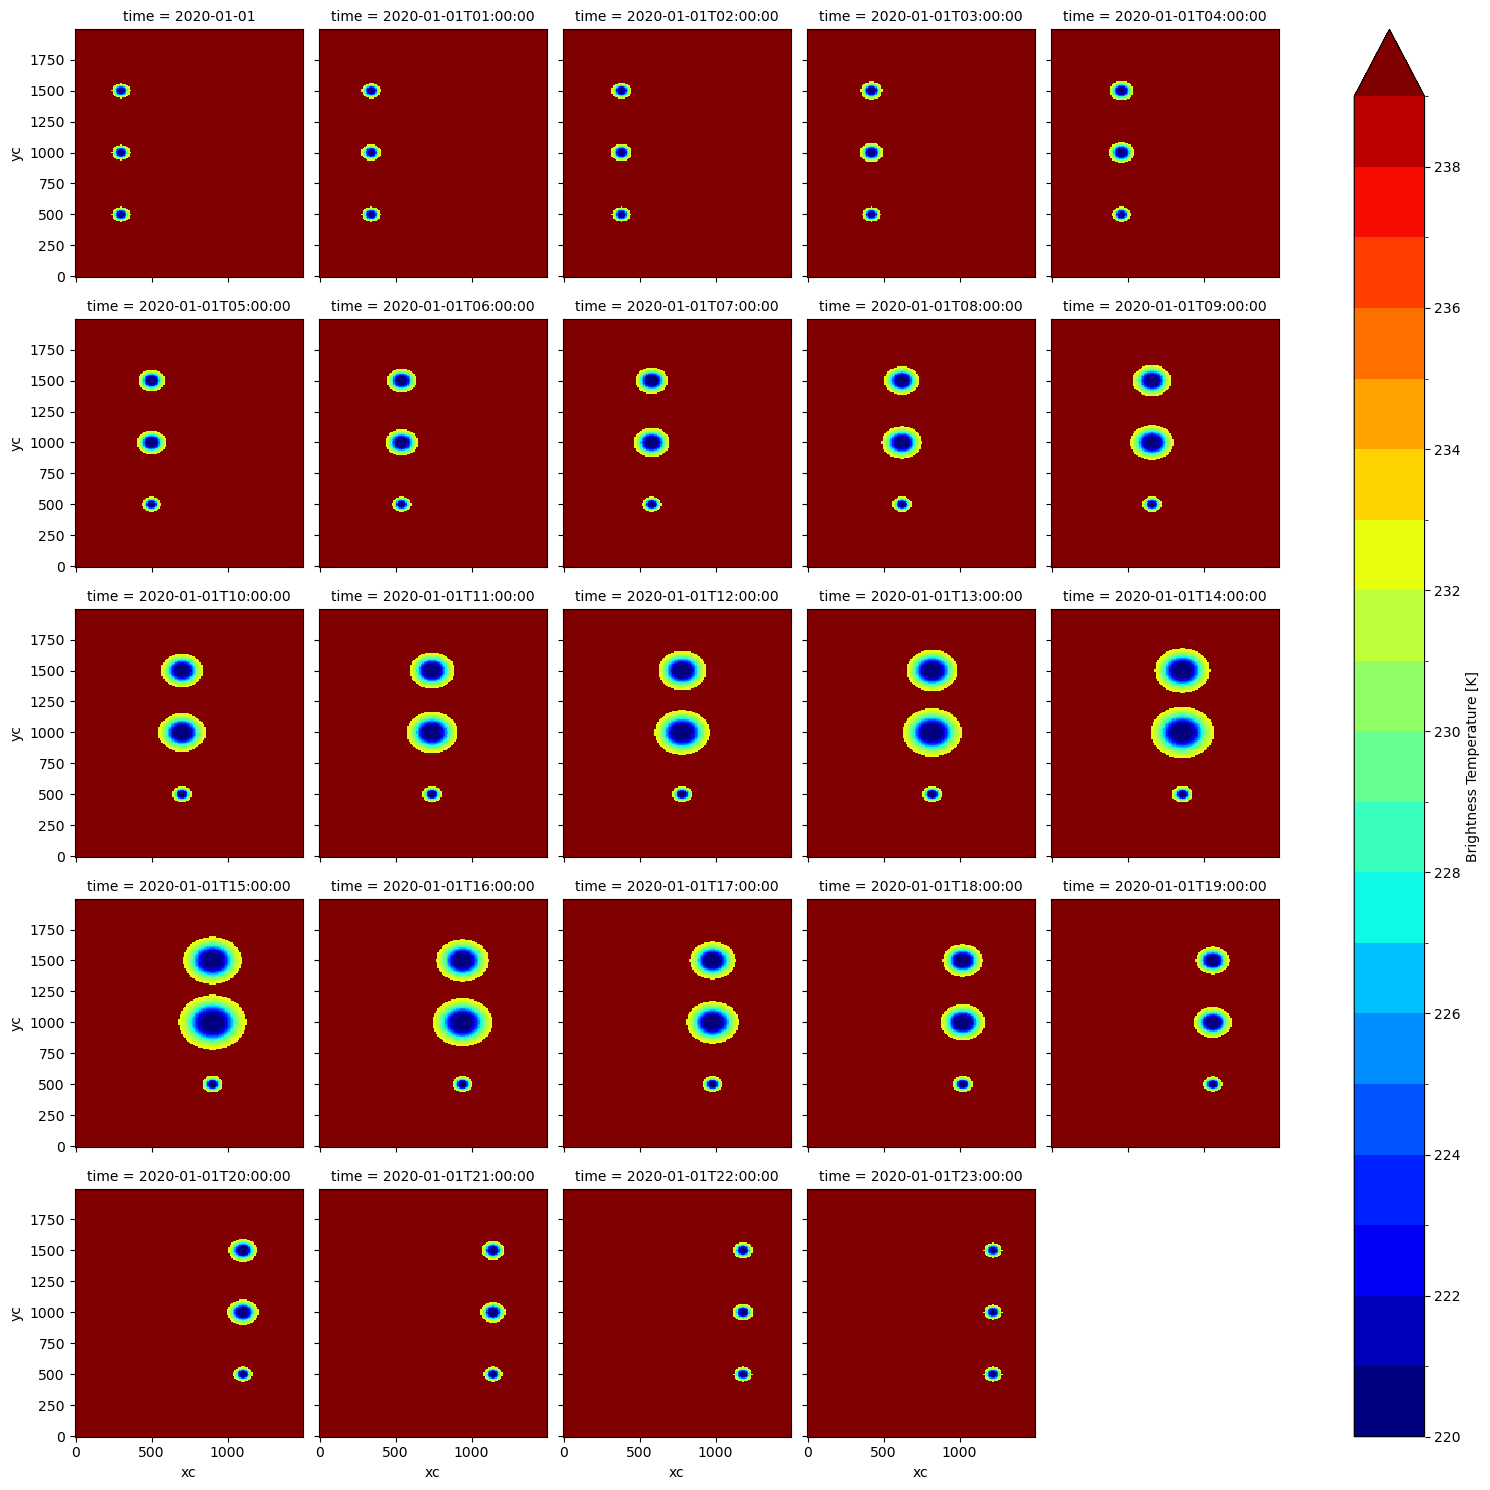

In [9]:
test.Tb.plot(col='time',col_wrap=5,levels=np.arange(220,240),cmap='jet')

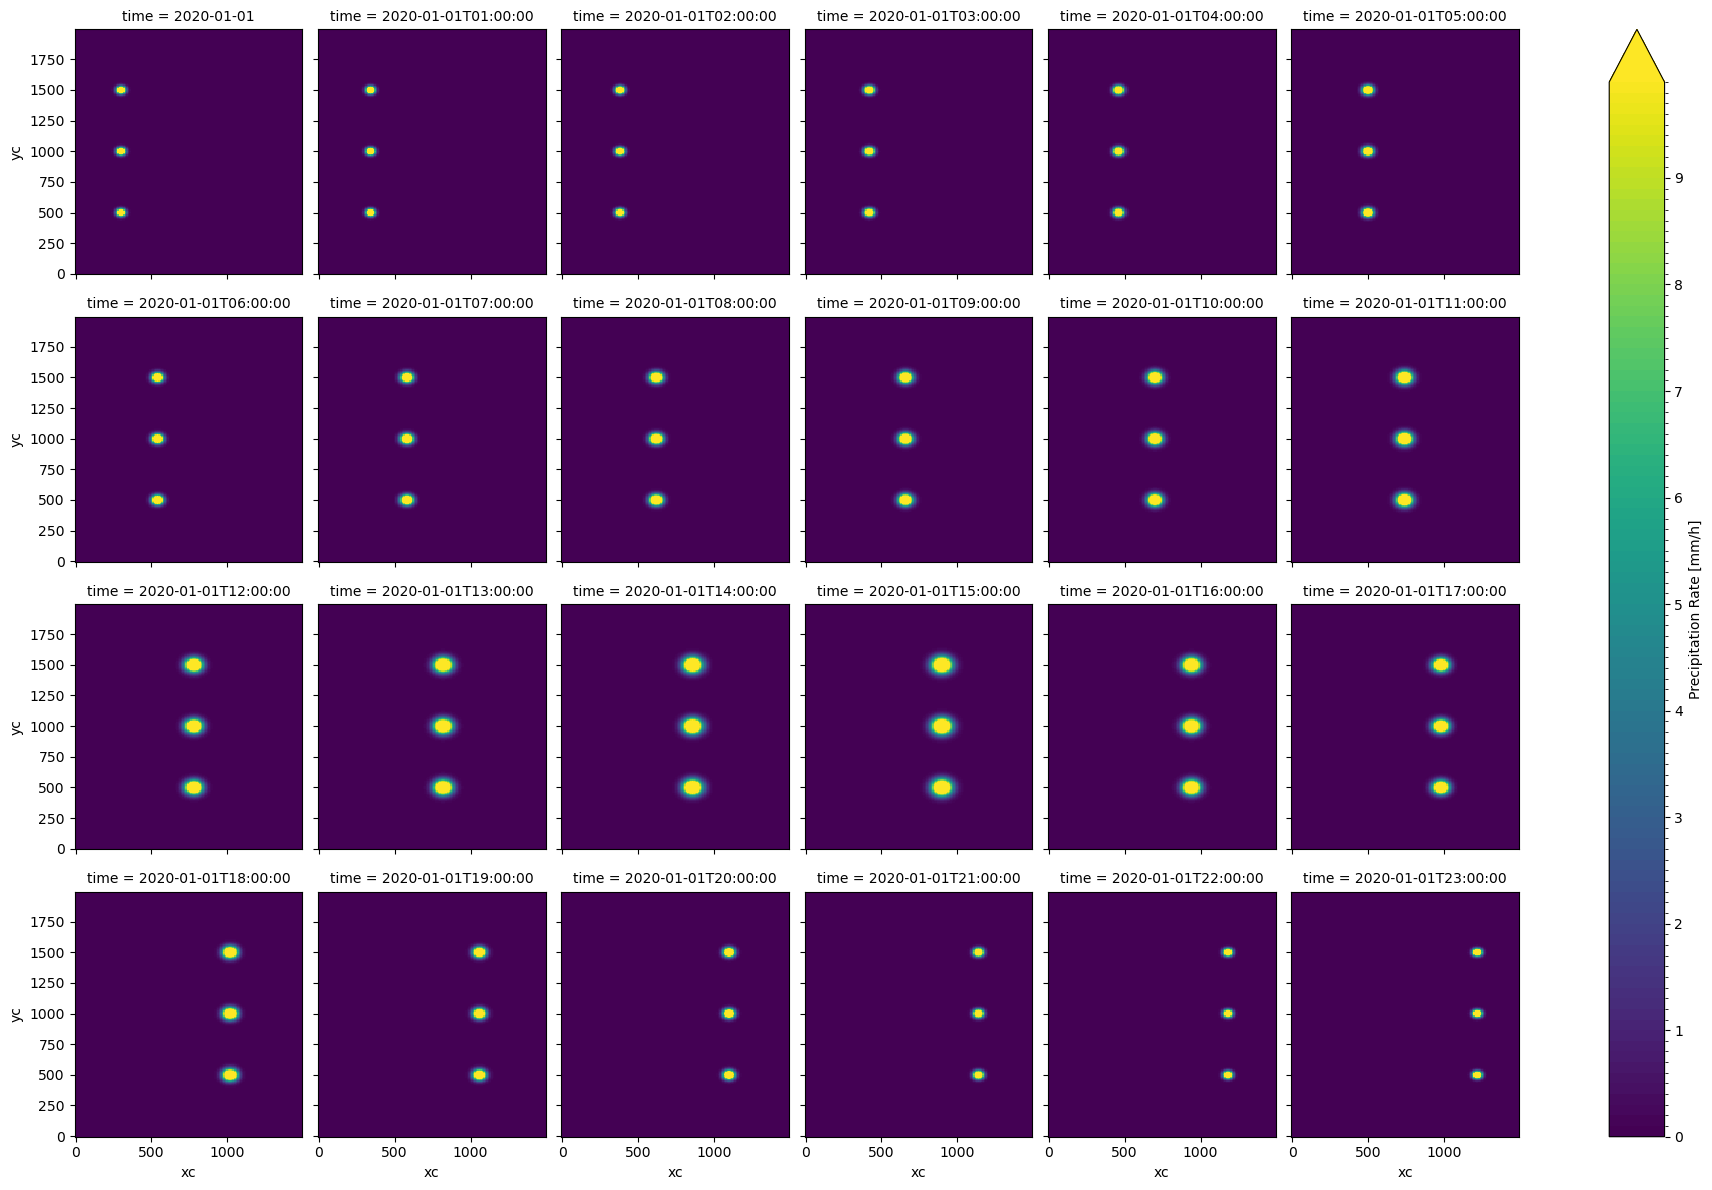

In [10]:
test.pr.plot(col='time',levels=np.arange(0,10,.1),col_wrap=6)

### 6. Roll the Synthetic Clouds to Test PBC

This section applies periodic boundary conditions by rolling the cloud data along one or more axes.

In [11]:
# rolled_variables = test[['Tb', 'pr']].roll(xc=70,yc=70,roll_coords=False) 
# # Update the variables in the original dataset
# test[['Tb', 'pr']] = rolled_variables

In [12]:
# test.Tb.plot(col='time',levels=np.arange(220,240),x='xc',col_wrap=6)

In [13]:
# test.to_netcdf('./MCS5_demo_rolled_2020-01-01_00-00-00.nc')